# Kaggle Outbrain competition
https://www.kaggle.com/c/outbrain-click-prediction
#### This is an initial analysis of the data as part of the 'Create your Data Story' project for Springboard Data Science Intensive course.

In [2]:
# Imports
# pandas
import pandas as pd
from pandas import Series,DataFrame
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

## Lets first look at how many Ads (documents) are displayed each time in the training data...

In [5]:
clicks_train = pd.read_csv('./data/clicks_train.csv',  dtype={"display_id": int, "ad_id": int, "clicked": int})

### Between 2 to 11 ads were shown each time

### Displays with 4 or 6 ads were atleast thrice more likely than displays of any other number of ads

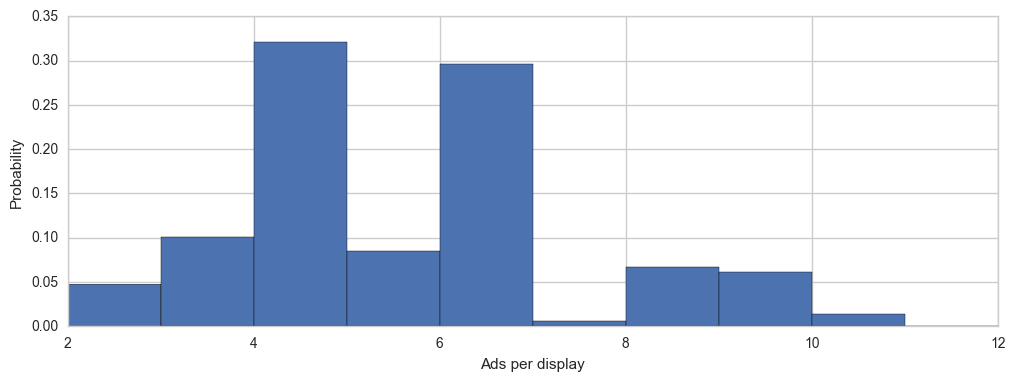

In [3]:
plt.figure(figsize=(12,4))
ax = clicks_train['ad_id'].groupby(clicks_train['display_id']).size().hist(normed=1)
ax.set_xlabel("Ads per display")
ax.set_ylabel("Probability")

## Now lets look at the Click Thru Rate distribution for these ads...

In [6]:
train_grp_ad = clicks_train.groupby(clicks_train['ad_id'])

In [8]:
ctr = train_grp_ad['clicked'].mean()

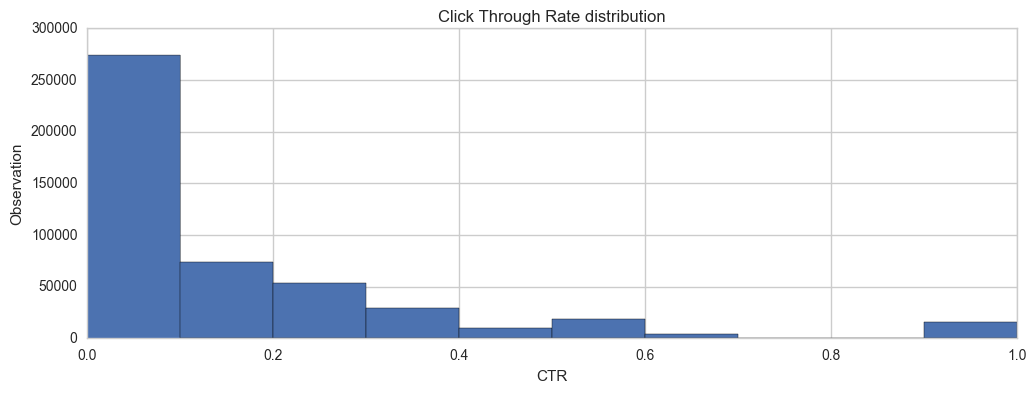

In [5]:
plt.figure(figsize=(12,4))
ax = ctr.hist(bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_xlabel("CTR")
ax.set_ylabel("Observation")
plt.title("Click Through Rate distribution")

## The Click through rate is right skewed and around 14% on average. This can be attributed to the fact that for each display ID only one of the x number of ads displayed is clicked.

In [6]:
ctr.mean()

0.143224101154019

## how many ads were clicked at least once?

In [8]:
c = train_grp_ad['clicked'].sum()

In [53]:
all_clicked = c[c != 0]

In [55]:
not_clicked = c[c == 0]

In [61]:
not_clicked.shape[0] * 100 /c.shape[0]

46.938928906984025

### Only 53% ads were clicked at least once in other words 47% of ads were not even clicked once

## And how often were the ads repeated?

In [9]:
repeat = train_grp_ad['clicked'].count()

In [10]:
repeat.mean()

181.9432738281658

In [13]:
repeat.max() - repeat.min()

211823

## Each Ad was repeated on an average 182 times

## Given the large number of ads and the large range of reptition rate, lets check the median of the ad repition.

In [11]:
repeat.median()

5.0

### So atleast half of the ad were repeated 5 or more times.

## Is there is relationship between the number of times an ad is repeated and it's CTR?

In [75]:
repeat.corr(ctr)

0.022056326354103151

## Corelation is almost 0

## But how about only ads that were clicked atleast once?

In [82]:
repeat.corr(ctr[ctr > 0])

-0.041137348769934606

## There is a negative correlation as expected but it is still negligible

## But how frequently and at what times did these click happen? 
## For that lets look at the distribution of the display_ids...

In [17]:
events_df = pd.read_csv('./data/events.csv',  dtype={"display_id": int, "uuid": str, "document_id": int, "timestamp": int, "platform": str, "geo_location": str})

In [85]:
timestamps = events_df.timestamp
## normalization to start of day
timestamps = ((((timestamps + 1465876799998)/1000)//(3600*24)) * 3600 * 24).apply(datetime.fromtimestamp)


### These are how ads were clicked over the 15 day period

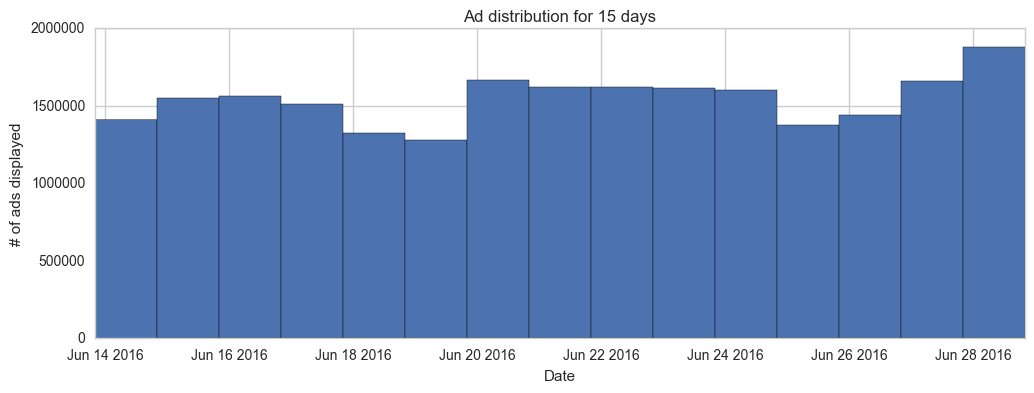

In [9]:
plt.figure(figsize=(12,4))
ax = timestamps.hist(bins=15)
ax.set_xlabel("Date")
ax.set_ylabel("# of ads displayed")
plt.title("Ad distribution for 15 days")

### This indicates that the number of ads clicked daily remained failry constant through out the 15 day window

### How about distribution of ad during the day? Where there times during the day where more ads were clicked?

In [10]:
## normalization to start of hour
timestamps_hrly = (events_df.timestamp // (3600 * 1000)) % 24


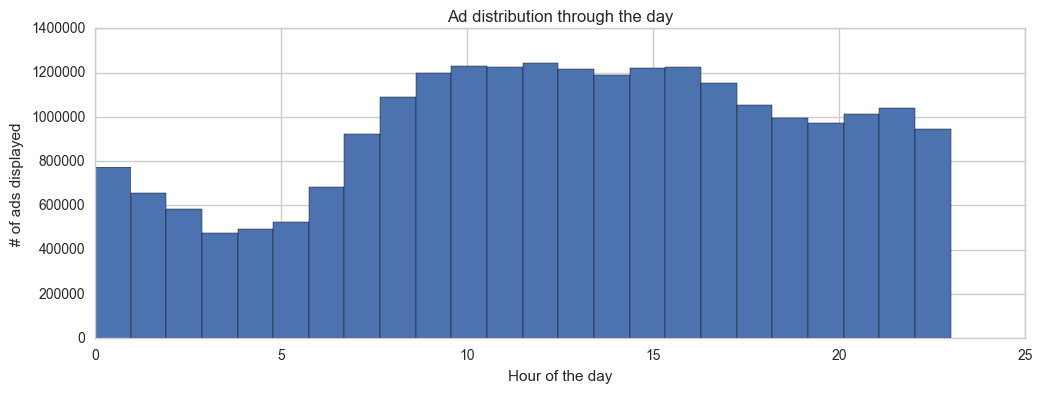

In [11]:
plt.figure(figsize=(12,4))
ax = timestamps_hrly.hist(bins=24)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("# of ads displayed")
plt.title("Ad distribution through the day")

0 is

GMT: Tue, 14 Jun 2016 03:59:59.998 GMT

US Eastern: Monday, June 13, 2016 11:59:59 PM GMT-4:00 DST

since the problem definition says,

>" If you wish to recover the actual epoch time of the visit, add 1465876799998 to the timestamp."

1465876799998 is 12:00 June 13th US Eastern"


### It appears that acitivity picks up after 8:00am in the morning till around 5:00pm in the evening which is the regular business hours and then around 6:00 pm to 11:00pm in the night.

## Now lets look at where the user traffic is originating from

In [18]:
map = events_df['geo_location'].drop_duplicates()

In [19]:
map = map.str.split('>', expand=True).rename(columns={0:'Country', 1:'State', 2: 'DMA'}).join(map)

In [20]:
a = pd.merge(events_df, map, on='geo_location')

In [21]:
geogrp = a.groupby(['Country'])  #, 'State', 'DMA'])

In [22]:
x = geogrp.size().sort_values(ascending=False)

In [23]:
x = x * 100/x.sum()

In [24]:
y = x.sort_values(ascending=False).head(10)

## Distribution by Users by Country (top 10)

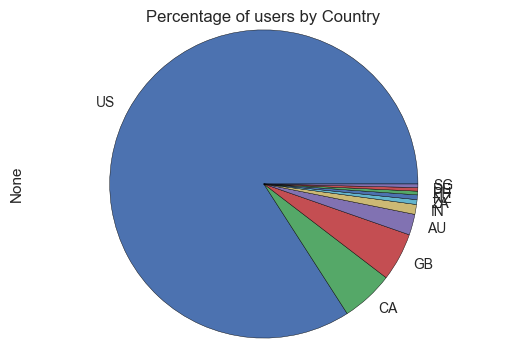

In [33]:
y.plot(kind='pie')
plt.axis('equal')
plt.title('Percentage of users by Country')

### Most of the clicks came from US based users. 

### So lets for a minute focus our attention on only the US based customers

In [26]:
usgrp = geogrp.get_group('US')

In [27]:
state = usgrp.groupby(['State'])

In [28]:
state_series = state.size().sort_values(ascending=False)

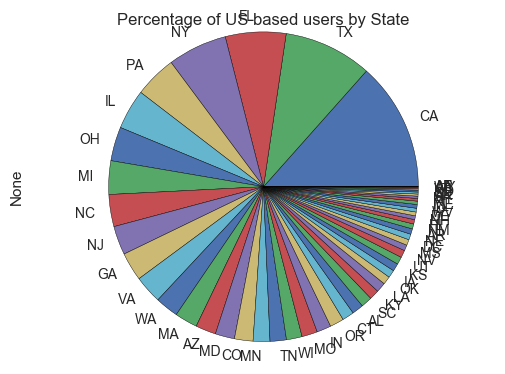

In [36]:
percent_by_state = state_series * 100/state_series.sum()
percent_by_state.plot(kind='pie')
plt.axis('equal')
plt.title('Percentage of US based users by State')

### Looking at the pie chart above it seems that although California has the highest percentage of users, all States are almost equally active

Using https://pypi.python.org/pypi/us

In [38]:
!pip install us
import us

You are using pip version 7.0.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [39]:
timeoffset = {'America/New_York': 0, 'America/Chicago': 60*60*1000, 'America/Denver': 2 * 60*60*1000, 'America/Los_Angeles': 3* 60*60*1000, 'Pacific/Honolulu':5 * 60*60*1000, 'America/North_Dakota/Center': 60*60*1000, 'America/Indiana/Indianapolis':0, 'America/Anchorage':4*60*60*1000 }

In [40]:
usgrp = usgrp[usgrp['State'] != 'AA']

In [41]:
usgrp = usgrp[usgrp['State'] != 'AE']

In [42]:
usgrp = usgrp[usgrp['State'] != 'AP']

In [43]:
usgrp = usgrp[usgrp['State'].isnull() == False]

In [46]:
time_adjust = lambda x: x['timestamp'] + timeoffset[us.states.lookup(x['State']).time_zones[0]]
usgrp['time_adjust'] = usgrp.apply(time_adjust, axis=1)

In [47]:
timestamps_hrly = (usgrp.time_adjust // (3600 * 1000)) % 24

### Lets look at the distribution of the ads through out the day but this time only for the US based customers and timeshifted such that 8:00AM in NewYork is also 8:00 AM in California, 8:00 AM in Chicago etc.

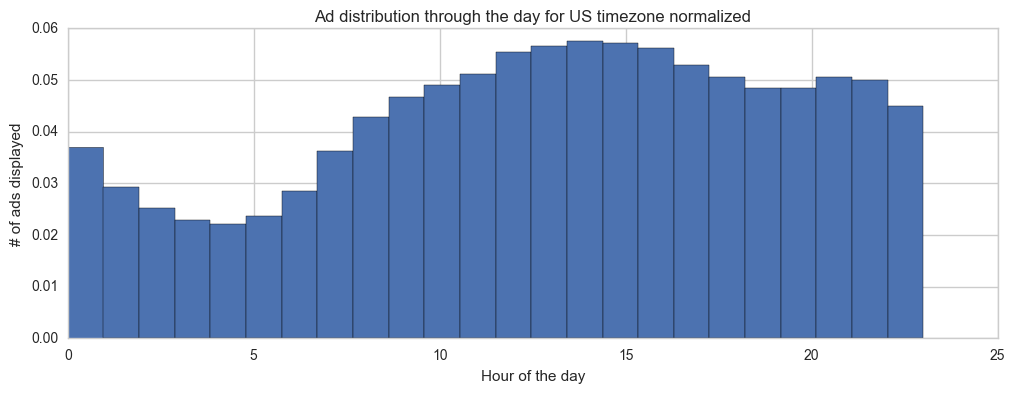

In [48]:
plt.figure(figsize=(12,4))
ax = timestamps_hrly.hist(bins=24, normed=True)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("# of ads displayed")
plt.title("Ad distribution through the day for US timezone normalized")

### The above graph re-iterates our understanding that most of the user activity is during the normal business hours

## So what is being asked here again?
## Well, we need to predict the probability of an ad in the test set being clicked.
## So lets compare the training and the test set to understand what we need to predict...

In [12]:
train = clicks_train.drop_duplicates(['display_id']).merge(events_df[['display_id', 'timestamp']])

In [13]:
clicks_test = pd.read_csv('./data/clicks_test.csv',  dtype={"display_id": int, "ad_id": int, "clicked": int})
test = clicks_test.drop_duplicates(['display_id'])

In [14]:
test = test.merge(events_df[['display_id', 'timestamp']])
train_daily = ((((train.timestamp + 1465876799998)/1000)//(3600*24)) * 3600 * 24).apply(datetime.fromtimestamp)
test_daily = ((((test.timestamp + 1465876799998)/1000)//(3600*24)) * 3600 * 24).apply(datetime.fromtimestamp)

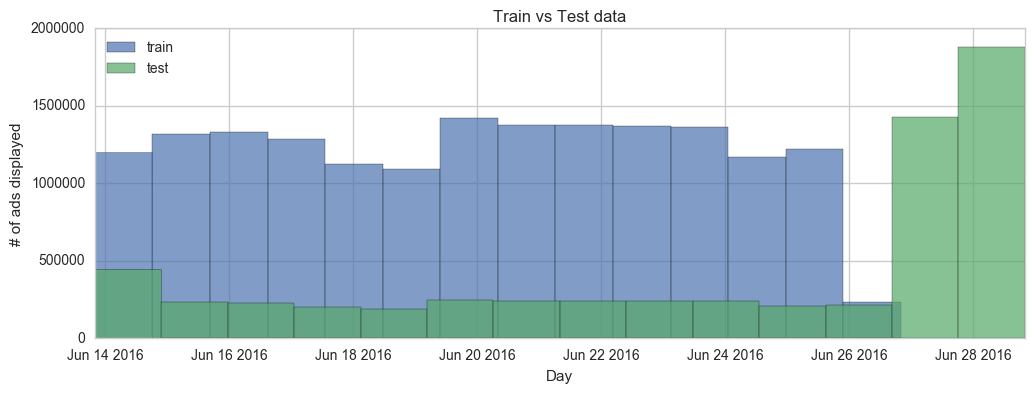

In [15]:
plt.figure(figsize=(12,4))
ax = train_daily.hist(bins=14, label="train", alpha=0.7)
test_daily.hist(bins=14, label="test", alpha=0.7)
ax.set_xlabel("Day")
ax.set_ylabel("# of ads displayed")
plt.title("Train vs Test data")
plt.legend(loc="best")

### Thus the prediction here for June 14th to June 28th. For the last two days there is no train data

## Finally, lets look at topics, entities and categories these document belong to

In [16]:
topics = pd.read_csv('./data/documents_topics.csv',  dtype={"document_id": int, "topic_id": int, "confidence_level": float})
categories = pd.read_csv('./data/documents_categories.csv',  dtype={"document_id": int, "category_id": int, "confidence_level": float})
entities = pd.read_csv('./data/documents_entities.csv',  dtype={"document_id": int, "entity_id": str, "confidence_level": float})

### There are 300 unique topics, 97 unique categories and unique 1,326,009 entities

In [17]:
len(topics['topic_id'].unique())

300

In [18]:
len(categories['category_id'].unique())

97

In [19]:
len(entities['entity_id'].unique())

1326009

## What next?
### This was just a basic statistical analysis of the data. More indepth analysis and modeling is needed to make prediction for the test data set.